In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn import over_sampling, under_sampling
from imblearn.pipeline import Pipeline
import gc
from sklearn.preprocessing import MinMaxScaler


In [3]:
train_transaction_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity_data = pd.read_csv( "/kaggle/input/ieee-fraud-detection/train_identity.csv")
test_transaction_data = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")
test_identity_data = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")
submission=pd.read_csv("/kaggle/input/ieee-fraud-detection/sample_submission.csv")


In [4]:
print(train_transaction_data.shape) 
print(train_identity_data.shape )
print(test_transaction_data.shape) 
print(test_identity_data.shape) 
print(submission.shape)

(590540, 394)
(144233, 41)
(506691, 393)
(141907, 41)
(506691, 2)


In [5]:
L=[train_transaction_data, train_identity_data, test_transaction_data,test_identity_data ]

In [6]:
# reduce memory data function
def reduce_mem_usage(df):
    for col in df.columns:
        col_type=df[col].dtypes
        if df[col].dtypes != object:
            col_type_min = df[col].min()
            col_type_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if col_type_min > np.iinfo(np.int8).min and col_type_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_type_min> np.iinfo(np.int16).min and col_type_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_type_min> np.iinfo(np.int32).min and col_type_max< np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_type_min > np.iinfo(np.int64).min and col_type_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_type_min > np.finfo(np.float16).min and col_type_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_type_min> np.finfo(np.float32).min and col_type_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

for i in L:
    i=reduce_mem_usage(i)

In [7]:
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
train_transaction_data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.0000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0

In [8]:
print(train_transaction_data.shape) 
print(train_identity_data.shape )
print(test_transaction_data.shape) 
print(test_identity_data.shape) 
print(submission.shape)

(590540, 394)
(144233, 41)
(506691, 393)
(141907, 41)
(506691, 2)


In [9]:
import gc
del L
gc.collect()


40

In [10]:
Train_Dataset_after_merge=pd.merge(train_transaction_data, train_identity_data, on="TransactionID",how='left')
Test_Dataset_after_merge=pd.merge(test_transaction_data, test_identity_data, on="TransactionID",how='left')

In [11]:
#Train_Dataset_after_merge=reduce_mem_usage(Train_Dataset_after_merge)
#Test_Dataset_after_merge=reduce_mem_usage(Test_Dataset_after_merge)

In [12]:
def differentcolumns(Train, Test):
    L=[]
    for i in Test:
        if i not in Train:
            L.append(i)
    return(L)
Different_name=differentcolumns(Train_Dataset_after_merge,Test_Dataset_after_merge)
print(Different_name)
type(Different_name)

['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']


list

In [13]:
for name in Different_name:
    #print(name)
    #type(name)
    l=name.split(sep='-')
    #print(l)
    name_new=str(l[0])+'_'+str(l[1])
    #print(name_new)
    Test_Dataset_after_merge=Test_Dataset_after_merge.rename(columns={name:name_new})

In [14]:
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
Test_Dataset_after_merge

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa

In [15]:
print(Train_Dataset_after_merge.shape)
print(Test_Dataset_after_merge.shape)


(590540, 434)
(506691, 433)


In [16]:
#del(train_transaction_data)
#del(train_identity_data)
#del(test_transaction_data)
#del(test_identity_data) 
gc.collect()

40

In [17]:
percent_missing = [Train_Dataset_after_merge.isnull().sum() * 100 / len(Train_Dataset_after_merge)]
percent_missing

[TransactionID      0.000000
 isFraud            0.000000
 TransactionDT      0.000000
 TransactionAmt     0.000000
 ProductCD          0.000000
                     ...    
 id_36             76.126088
 id_37             76.126088
 id_38             76.126088
 DeviceType        76.155722
 DeviceInfo        79.905510
 Length: 434, dtype: float64]

In [18]:
Train_Dataset_after_merge =Train_Dataset_after_merge.loc[:, (Train_Dataset_after_merge.isnull().sum() * 100 / len(Train_Dataset_after_merge)<80)]

In [19]:
Y=Train_Dataset_after_merge['isFraud']
T_ID_Train=Train_Dataset_after_merge['TransactionID']
T_ID_Test=Test_Dataset_after_merge['TransactionID']

In [20]:
cols=Train_Dataset_after_merge.columns
cols_list=cols.tolist()
#print(cols_list)
cols_list.remove('isFraud')

In [21]:
Test_Dataset_after_merge=Test_Dataset_after_merge.loc[:,cols_list]

In [22]:
print(Train_Dataset_after_merge.shape)
print(Test_Dataset_after_merge.shape)


(590540, 360)
(506691, 359)


In [23]:
Train_Catagorical = Train_Dataset_after_merge.select_dtypes(include=['object']).copy()
Train_Catagorical.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [24]:
Train_Numerical=Train_Dataset_after_merge.drop(Train_Catagorical.columns, axis=1)
Train_Numerical.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [25]:
del Train_Dataset_after_merge
gc.collect()

20

In [26]:
Test_Catagorical = Test_Dataset_after_merge.select_dtypes(include=['object']).copy()
Test_Catagorical.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,visa,debit,gmail.com,NaN,T,T,F,NaN,NaN,F,T,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,visa,debit,aol.com,NaN,T,F,F,M0,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,hotmail.com,NaN,T,T,F,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,visa,debit,gmail.com,NaN,T,T,T,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W,mastercard,debit,gmail.com,NaN,T,T,T,NaN,NaN,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
Test_Numerical=Test_Dataset_after_merge.drop(Test_Catagorical.columns, axis=1)
Test_Numerical.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20
0,3663549,18403224,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,418.0,203.0,409.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,231.0,634.0,634.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,280.000000,77.000000,0.0000,280.000000,77.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [28]:
del Test_Dataset_after_merge
gc.collect()

20

In [29]:
print(Train_Catagorical.shape)
print(Train_Numerical.shape)
print(Test_Catagorical.shape)
print(Test_Numerical.shape)

(590540, 26)
(590540, 334)
(506691, 26)
(506691, 333)


In [30]:
Train_Catagorical[Train_Catagorical.columns]=Train_Catagorical[Train_Catagorical.columns].mask(pd.isnull, 'un')
Train_Catagorical.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,un,un,T,T,T,M2,F,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
1,W,mastercard,credit,gmail.com,un,un,un,un,M0,T,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
2,W,visa,debit,outlook.com,un,T,T,T,M0,F,F,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un
3,W,mastercard,debit,yahoo.com,un,un,un,un,M0,T,F,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
4,H,mastercard,credit,gmail.com,un,un,un,un,un,un,un,un,un,un,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [31]:
Train_Catagorical

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,discover,credit,un,un,T,T,T,M2,F,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
1,W,mastercard,credit,gmail.com,un,un,un,un,M0,T,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
2,W,visa,debit,outlook.com,un,T,T,T,M0,F,F,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un
3,W,mastercard,debit,yahoo.com,un,un,un,un,M0,T,F,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
4,H,mastercard,credit,gmail.com,un,un,un,un,un,un,un,un,un,un,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,visa,debit,un,un,T,T,T,M0,T,F,F,F,T,un,un,un,un,un,un,un,un,un,un,un,un
590536,W,mastercard,debit,gmail.com,un,T,F,F,M0,F,T,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un
590537,W,mastercard,debit,gmail.com,un,T,F,F,un,un,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
590538,W,mastercard,debit,aol.com,un,T,T,T,M0,F,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un


In [32]:
Train_Catagorical.nunique()

ProductCD           5
card4               5
card6               5
P_emaildomain      60
R_emaildomain      61
M1                  3
M2                  3
M3                  3
M4                  4
M5                  3
M6                  3
M7                  3
M8                  3
M9                  3
id_12               3
id_15               4
id_16               3
id_28               3
id_29               3
id_31             131
id_35               3
id_36               3
id_37               3
id_38               3
DeviceType          3
DeviceInfo       1787
dtype: int64

In [33]:
Test_Catagorical[Test_Catagorical.columns]=Test_Catagorical[Test_Catagorical.columns].mask(pd.isnull, 'un')
Test_Catagorical.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,visa,debit,gmail.com,un,T,T,F,un,un,F,T,T,T,un,un,un,un,un,un,un,un,un,un,un,un
1,W,visa,debit,aol.com,un,T,F,F,M0,un,F,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
2,W,visa,debit,hotmail.com,un,T,T,F,M0,F,F,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un
3,W,visa,debit,gmail.com,un,T,T,T,un,un,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
4,W,mastercard,debit,gmail.com,un,T,T,T,un,un,F,F,T,T,un,un,un,un,un,un,un,un,un,un,un,un


In [34]:
Test_Catagorical

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,visa,debit,gmail.com,un,T,T,F,un,un,F,T,T,T,un,un,un,un,un,un,un,un,un,un,un,un
1,W,visa,debit,aol.com,un,T,F,F,M0,un,F,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
2,W,visa,debit,hotmail.com,un,T,T,F,M0,F,F,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un
3,W,visa,debit,gmail.com,un,T,T,T,un,un,T,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
4,W,mastercard,debit,gmail.com,un,T,T,T,un,un,F,F,T,T,un,un,un,un,un,un,un,un,un,un,un,un
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,C,mastercard,debit,gmail.com,gmail.com,un,un,un,M2,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un,un
506687,C,mastercard,debit,hotmail.com,hotmail.com,un,un,un,M2,un,un,un,un,un,NotFound,New,NotFound,New,NotFound,chrome 43.0 for android,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,W,visa,debit,hotmail.com,un,T,T,T,M0,F,F,F,T,T,un,un,un,un,un,un,un,un,un,un,un,un
506689,W,mastercard,debit,hotmail.com,un,T,T,T,M0,F,F,F,F,F,un,un,un,un,un,un,un,un,un,un,un,un


In [35]:
Test_Catagorical.nunique()

ProductCD           5
card4               5
card6               4
P_emaildomain      61
R_emaildomain      61
M1                  3
M2                  3
M3                  3
M4                  4
M5                  3
M6                  3
M7                  3
M8                  3
M9                  3
id_12               3
id_15               4
id_16               3
id_28               3
id_29               3
id_31             136
id_35               3
id_36               3
id_37               3
id_38               3
DeviceType          3
DeviceInfo       2227
dtype: int64

In [36]:
!pip install dython

In [37]:
from dython import nominal

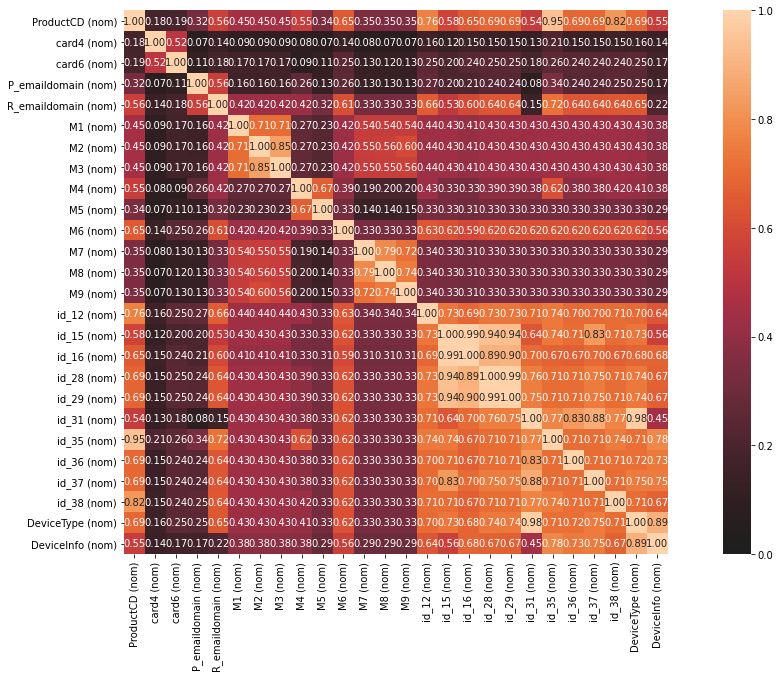

In [38]:
nominal.associations(Train_Catagorical,figsize=(20,10),mark_columns=True);

1)id_15,id_29,id_16,id_28

2)id_31, DeviceType, DeviceInfo



In [39]:
Train_Catagorical=Train_Catagorical.drop(['id_15', 'id_28', 'id_29'], axis='columns')

In [40]:
Train_Catagorical=Train_Catagorical.drop(['DeviceInfo'], axis='columns')

In [41]:
Test_Catagorical=Test_Catagorical.drop(['id_15', 'id_28', 'id_29', 'DeviceInfo'], axis='columns')

In [42]:
Test_Catagorical.shape

(506691, 22)

In [43]:
Train_Catagorical.shape

(590540, 22)

In [44]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
 
features = []; categorical_features = []
num_of_columns = Train_Catagorical.shape[1]
 
for i in range(0, num_of_columns):
    column_name = Train_Catagorical.columns[i]
    column_type =Train_Catagorical[column_name].dtype
    le.fit(Train_Catagorical[column_name])
    feature_classes = list(le.classes_)
    encoded_feature = le.transform(Train_Catagorical[column_name])
    Train_Catagorical[column_name] = pd.DataFrame(encoded_feature)
 


In [45]:
Train_Catagorical

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_16,id_31,id_35,id_36,id_37,id_38,DeviceType
0,4,1,1,48,49,1,1,1,2,0,1,2,2,2,2,2,129,2,2,2,2,2
1,4,2,1,16,49,2,2,2,0,1,1,2,2,2,2,2,129,2,2,2,2,2
2,4,4,2,35,49,1,1,1,0,0,0,0,0,0,2,2,129,2,2,2,2,2
3,4,2,2,54,49,2,2,2,0,1,0,2,2,2,2,2,129,2,2,2,2,2
4,1,2,1,16,49,2,2,2,3,2,2,2,2,2,1,1,123,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,4,4,2,48,49,1,1,1,0,1,0,0,0,1,2,2,129,2,2,2,2,2
590536,4,2,2,16,49,1,0,0,0,0,1,0,0,0,2,2,129,2,2,2,2,2
590537,4,2,2,16,49,1,0,0,3,2,1,2,2,2,2,2,129,2,2,2,2,2
590538,4,2,2,2,49,1,1,1,0,0,1,2,2,2,2,2,129,2,2,2,2,2


In [46]:
col_cat=list(Train_Catagorical.columns)

In [47]:
scaler= MinMaxScaler()
scaler.fit(Train_Catagorical)
scaled_Train_Catagorical=scaler.transform(Train_Catagorical)

In [48]:
Train_Catagorical= pd.DataFrame(scaled_Train_Catagorical, columns = col_cat)

In [49]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
 
features = []; categorical_features = []
num_of_columns =Test_Catagorical.shape[1]
 
for i in range(0, num_of_columns):
    column_name = Test_Catagorical.columns[i]
    column_type =Test_Catagorical[column_name].dtype
    le.fit(Test_Catagorical[column_name])
    feature_classes = list(le.classes_)
    encoded_feature = le.transform(Test_Catagorical[column_name])
    Test_Catagorical[column_name] = pd.DataFrame(encoded_feature)
 

In [50]:
Test_Catagorical

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_16,id_31,id_35,id_36,id_37,id_38,DeviceType
0,4,4,2,16,49,1,1,0,3,2,0,1,1,1,2,2,135,2,2,2,2,2
1,4,4,2,2,49,1,0,0,0,2,0,2,2,2,2,2,135,2,2,2,2,2
2,4,4,2,19,49,1,1,0,0,0,0,0,0,0,2,2,135,2,2,2,2,2
3,4,4,2,16,49,1,1,1,3,2,1,2,2,2,2,2,135,2,2,2,2,2
4,4,2,2,16,49,1,1,1,3,2,0,0,1,1,2,2,135,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,0,2,2,16,16,2,2,2,2,2,2,2,2,2,2,2,135,2,2,2,2,2
506687,0,2,2,19,19,2,2,2,2,2,2,2,2,2,1,1,5,0,0,1,0,1
506688,4,4,2,19,49,1,1,1,0,0,0,0,1,1,2,2,135,2,2,2,2,2
506689,4,2,2,19,49,1,1,1,0,0,0,0,0,0,2,2,135,2,2,2,2,2


In [51]:
scaler= MinMaxScaler()
scaler.fit(Test_Catagorical)
scaled_Test_Catagorical=scaler.transform(Test_Catagorical)

In [52]:
Test_Catagorical= pd.DataFrame(scaled_Test_Catagorical, columns = col_cat)

In [53]:
Test_Catagorical.corr()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_16,id_31,id_35,id_36,id_37,id_38,DeviceType
ProductCD,1.000000,0.078951,0.221104,0.204045,0.784447,-0.808762,-0.743014,-0.705755,-0.207384,-0.436500,-0.759567,-0.613384,-0.582361,-0.582939,0.795180,0.763238,0.823602,0.937266,0.887445,0.815618,0.891142,0.796580
card4,0.078951,1.000000,0.147207,0.028511,0.103150,-0.091363,-0.084358,-0.079663,-0.022031,-0.034420,-0.080687,-0.070476,-0.062202,-0.064487,0.105313,0.090470,0.083393,0.080481,0.100666,0.095994,0.102781,0.104337
card6,0.221104,0.147207,1.000000,0.073491,0.264772,-0.283120,-0.255100,-0.237827,-0.140670,-0.128332,-0.304357,-0.213471,-0.193480,-0.195757,0.326237,0.283910,0.238482,0.203002,0.297353,0.291322,0.259616,0.321125
P_emaildomain,0.204045,0.028511,0.073491,1.000000,0.254467,-0.143673,-0.126170,-0.116288,0.009497,-0.038646,-0.130154,-0.103662,-0.095806,-0.100443,0.126962,0.130356,0.145189,0.172592,0.160251,0.148355,0.186610,0.143061
R_emaildomain,0.784447,0.103150,0.264772,0.254467,1.000000,-0.731766,-0.672277,-0.638565,-0.246613,-0.394945,-0.687255,-0.554989,-0.526919,-0.527442,0.772963,0.710665,0.735011,0.768069,0.802591,0.736027,0.804183,0.759812
M1,-0.808762,-0.091363,-0.283120,-0.143673,-0.731766,1.000000,0.918623,0.872560,0.290588,0.424918,0.711440,0.751373,0.712546,0.710760,-0.800886,-0.734866,-0.743711,-0.773504,-0.828105,-0.771858,-0.792687,-0.778048
M2,-0.743014,-0.084358,-0.255100,-0.126170,-0.672277,0.918623,1.000000,0.919993,0.280341,0.405979,0.658690,0.694912,0.670843,0.688494,-0.735778,-0.675125,-0.683251,-0.710622,-0.760784,-0.709110,-0.728245,-0.714796
M3,-0.705755,-0.079663,-0.237827,-0.116288,-0.638565,0.872560,0.919993,1.000000,0.261117,0.377846,0.623314,0.655632,0.628357,0.635972,-0.698882,-0.641270,-0.648989,-0.674987,-0.722634,-0.673551,-0.691727,-0.678952
M4,-0.207384,-0.022031,-0.140670,0.009497,-0.246613,0.290588,0.280341,0.261117,1.000000,0.827223,0.271399,0.132575,0.153093,0.147535,-0.325770,-0.272994,-0.235017,-0.189640,-0.297514,-0.298379,-0.239661,-0.282701
M5,-0.436500,-0.034420,-0.128332,-0.038646,-0.394945,0.424918,0.405979,0.377846,0.827223,1.000000,0.396451,0.248360,0.260774,0.274691,-0.432250,-0.396617,-0.401392,-0.417471,-0.446940,-0.416583,-0.427824,-0.419924


In [54]:
#L1=[Train_Catagorical[col].value_counts().to_dict() for col in Train_Catagorical.columns ]

In [55]:
#L1

In [56]:
#L2=[Test_Catagorical[col].value_counts().to_dict() for col in Test_Catagorical.columns ]

In [57]:
#cols_cat1=[cols for cols in Train_Catagorical.columns ]
#for i in range(len(Train_Catagorical.columns)):
    #print(i)
    #Train_Catagorical[cols_cat1[i]]=Train_Catagorical[cols_cat1[i]].map(L1[i])

In [58]:
#Train_Catagorical

In [59]:
#cols_cat2=[cols for cols in Test_Catagorical.columns ]
#for i in range(len(Test_Catagorical.columns)):
    ##print(i)
    #Test_Catagorical[cols_cat2[i]]=Test_Catagorical[cols_cat2[i]].map(L2[i])

In [60]:
 #Test_Catagorical

In [61]:
cols=Train_Numerical.columns
cols_list=cols.tolist()
#print(cols_list)
cols_list.remove('isFraud')

#print(cols_list)

In [62]:
print(cols_list)

['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V10

In [63]:

column_1 =Train_Numerical["isFraud"]
#column_2 =Train_Numerical[i]
cols_stay=[]


for i in cols_list:
    #print(i)
    column_2 =Train_Numerical[i]
    #column_1.corr(column_2)
    #type(0.1)
    
    if abs(round(column_1.corr(column_2),2))>0.05:
        cols_stay.append(i)
        #colstay
cols_stay

['card3',
 'D1',
 'D2',
 'D4',
 'D5',
 'D10',
 'D15',
 'V10',
 'V11',
 'V15',
 'V16',
 'V17',
 'V18',
 'V21',
 'V22',
 'V23',
 'V24',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V62',
 'V63',
 'V64',
 'V67',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V123',
 'V124',
 'V125',
 'V169',
 'V170',
 'V171',
 'V176',
 'V184',
 'V185',
 'V186',
 'V188',
 'V189',
 'V190',
 'V191',
 'V194',
 'V195',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V220',
 'V221',
 'V222',
 'V228',
 'V229',
 'V230',
 'V235',
 'V238',
 'V239',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V251',
 'V252',
 

In [64]:
Train_Numerical =Train_Numerical.loc[:,cols_stay]
Train_Numerical

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,14.0,NaN,NaN,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,150.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
2,150.0,0.0,NaN,0.0,NaN,0.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,150.0,112.0,112.0,94.0,0.0,84.0,111.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,150.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,166.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,150.0,29.0,29.0,NaN,NaN,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [65]:
Train_Numerical

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,14.0,NaN,NaN,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
1,150.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
2,150.0,0.0,NaN,0.0,NaN,0.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
3,150.0,112.0,112.0,94.0,0.0,84.0,111.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,150.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,166.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,150.0,29.0,29.0,NaN,NaN,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [66]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [67]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(Train_Numerical)
Train_Numerical_dpna =imp.transform(Train_Numerical.values)

    

In [68]:
del Train_Numerical

In [69]:
type(Train_Numerical_dpna)

numpy.ndarray

In [70]:
Train_Numerical_dpna_df = pd.DataFrame(Train_Numerical_dpna, columns = cols_stay)

In [71]:
del Train_Numerical_dpna

In [72]:
Train_Numerical_dpna_df

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,14.0,97.0,26.0,10.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-5.0,166.0,472.0
1,150.0,0.0,97.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-5.0,166.0,472.0
2,150.0,0.0,97.0,0.0,10.0,0.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-5.0,166.0,472.0
3,150.0,112.0,112.0,94.0,0.0,84.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,166.0,472.0
4,150.0,0.0,97.0,26.0,10.0,15.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,166.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,150.0,29.0,29.0,26.0,10.0,56.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0

In [73]:
from sklearn.preprocessing import MinMaxScaler

In [74]:
scaler= MinMaxScaler()
scaler.fit(Train_Numerical_dpna_df)
scaled_Train_Numerical=scaler.transform(Train_Numerical_dpna_df)

In [75]:
#scaled_Train_Numerical_df=

In [76]:
scaled_Train_Numerical

array([[0.3813 , 0.02187, 0.1515 , ..., 0.95   , 0.5117 , 0.663  ],
       [0.3813 , 0.     , 0.1515 , ..., 0.95   , 0.5117 , 0.663  ],
       [0.3813 , 0.     , 0.1515 , ..., 0.95   , 0.5117 , 0.663  ],
       ...,
       [0.3813 , 0.     , 0.1515 , ..., 0.95   , 0.5117 , 0.663  ],
       [0.3813 , 0.03436, 0.03436, ..., 0.95   , 0.5117 , 0.663  ],
       [0.3813 , 0.     , 0.1515 , ..., 0.95   , 0.5117 , 0.663  ]],
      dtype=float16)

In [77]:
#Train_Numerical_dpna=[Train_Numerical.columns].mask(pd.isnull,0)

In [78]:
# settings to display all columns
#pd.set_option("display.max_columns", None)
# display the dataframe head
#Train_Numerical.head()

In [79]:
Test_Numerical =Test_Numerical.loc[:,cols_stay]
Test_Numerical

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,419.0,419.0,398.0,27.0,418.0,409.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,150.0,149.0,149.0,634.0,7.0,231.0,634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,150.0,137.0,137.0,97.0,10.0,136.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,150.0,42.0,42.0,242.0,41.0,242.0,242.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,150.0,22.0,22.0,22.0,0.0,22.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,185.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1

In [80]:
# settings to display all columns
pd.set_option("display.max_columns", None)
# display the dataframe head
Test_Numerical.head()

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,419.0,419.0,398.0,27.0,418.0,409.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,150.0,149.0,149.0,634.0,7.0,231.0,634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,150.0,137.0,137.0,97.0,10.0,136.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,150.0,42.0,42.0,242.0,41.0,242.0,242.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,150.0,22.0,22.0,22.0,0.0,22.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN


In [81]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(Test_Numerical)
Test_Numerical_dpna =imp.transform(Test_Numerical.values)


In [82]:
del Test_Numerical

In [83]:
Test_Numerical_dpna_df = pd.DataFrame(Test_Numerical_dpna, columns = cols_stay)
Test_Numerical_dpna_df

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,150.0,419.0,419.0,398.0,27.0,418.0,409.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,166.0,484.0
1,150.0,149.0,149.0,634.0,7.0,231.0,634.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,166.0,484.0
2,150.0,137.0,137.0,97.0,10.0,136.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,166.0,484.0
3,150.0,42.0,42.0,242.0,41.0,242.0,242.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-5.0,166.0,484.0
4,150.0,22.0,22.0,22.0,0.0,22.0,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-5.0,166.0,484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,185.0,0.0,112.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.

In [84]:
scaler.fit(Test_Numerical_dpna_df)
scaled_Test_Numerical=scaler.transform(Test_Numerical_dpna_df)

In [85]:
scaled_Test_Numerical_df= pd.DataFrame(scaled_Test_Numerical, columns = cols_stay)

In [86]:
scaled_Test_Numerical_df

,card3,D1,D2,D4,D5,D10,D15,V10,V11,V15,V16,V17,V18,V21,V22,V23,V24,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V56,V57,V58,V59,V60,V62,V63,V64,V67,V69,V70,V71,V72,V73,V74,V77,V78,V79,V80,V81,V83,V84,V85,V86,V87,V90,V91,V92,V93,V94,V108,V109,V110,V111,V112,V113,V114,V115,V116,V123,V124,V125,V169,V170,V171,V176,V184,V185,V186,V188,V189,V190,V191,V194,V195,V197,V198,V199,V200,V201,V220,V221,V222,V228,V229,V230,V235,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V251,V252,V257,V258,V259,V260,V261,V262,V281,V282,V283,V302,V303,V304,id_01,id_17,id_20
0,0.378906,0.653809,0.653809,0.364746,0.024826,0.383057,0.374756,0.199951,0.142822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066650,0.034485,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.166626,0.020401,0.019226,0.000000,0.000000,0.000,0.000000,0.021271,0.014496,0.125,0.090881,0.25,0.142822,0.000000,0.000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.012497,0.012497,0.000000,0.000000,0.000000,0.142822,0.000000,0.000000,0.012497,0.012497,0.25,0.125,0.000000,0.000000,0.0,0.125,0.125,0.125,0.125,0.125,0.125,0.111084,0.111084,0.111084,0.083313,0.076904,0.083313,0.0,0.015869,0.014709,0.0,0.0,0.0,0.025635,0.02272,0.02272,0.004463,0.049988,0.142822,0.055542,0.090881,0.034485,0.004463,0.021271,0.021271,0.0,0.007141,0.003437,0.0,0.0,0.0,0.0,0.0,0.0,0.037048,0.018524,0.030304,0.008064,0.004463,0.090881,0.034485,0.052643,0.083313,0.047607,0.004463,0.003717,0.007633,0.071411,0.011238,0.029419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950195,0.515625,0.685547
1,0.378906,0.232422,0.232422,0.581055,0.006435,0.211670,0.581055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066650,0.034485,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.166626,0.020401,0.019226,0.000000,0.000000,0.000,0.000000,0.021271,0.014496,0.125,0.090881,0.00,0.000000,0.000000,0.000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.099976,0.000,0.000000,0.099976,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.012497,0.012497,0.000000,0.000000,0.000000,0.142822,0.000000,0.000000,0.012497,0.012497,0.00,0.000,0.000000,0.000000,0.0,0.125,0.125,0.125,0.125,0.125,0.125,0.111084,0.111084,0.111084,0.083313,0.076904,0.083313,0.0,0.015869,0.014709,0.0,0.0,0.0,0.025635,0.02272,0.02272,0.004463,0.049988,0.142822,0.055542,0.090881,0.034485,0.004463,0.021271,0.021271,0.0,0.007141,0.003437,0.0,0.0,0.0,0.0,0.0,0.0,0.037048,0.018524,0.030304,0.008064,0.004463,0.090881,0.034485,0.052643,0.083313,0.047607,0.004463,0.003717,0.007633,0.071411,0.011238,0.029419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950195,0.515625,0.685547
2,0.378906,0.213745,0.213745,0.088928,0.009193,0.124634,0.088928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133301,0.068970,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.166626,0.020401,0.019226,0.000000,0.000000,0.000,0.000000,0.021271,0.014496,0.125,0.090881,0.00,0.000000,0.000000,0.000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.099976,0.000,0.000000,0.099976,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.012497,0.024994,0.000000,0.000000,0.000000,0.285645,0.000000,0.000000,0.012497,0.012497,0.00,0.000,0.000000,0.000000,0.0,0.125,0.125,0.125,0.125,0.125,0.125,0.111084,0.111084,0.111084,0.083313,0.076904,0.083313,0.0,0.015869,0.014709,0.0,0.0,0.0,0.025635,0.02272,0.02272,0.004463,0.049988,0.142822,0.055542,0.090881,0.034485,0.004463,0.021271,0.021271,0.0,0.007141,0.003437,0.0,0.0,0.0,0.0,0.0,0.0,0.037048,0.018524,0.030304,0.008064,0.004463,0.090881,0.034485,0.052643,0.083313,0.047607,0.004463,0.003717,0.007633,0.071411,0.011238,0.029419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950195,0.515625,0.685547
3,0.378906,0.065552,0.065552,0.221802,0.037689,0.221802,0.221802,0.199951,0.142822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [87]:
from sklearn.decomposition import PCA


In [88]:
pca=PCA(n_components=15)

In [89]:
pca.fit(scaled_Train_Numerical)

PCA(n_components=15)

In [90]:
scaled_Train_Numerical_pca=pca.transform(scaled_Train_Numerical)

In [91]:

scaled_Train_Numerical_pca

array([[-0.21673751, -0.19767238, -0.17622694, ..., -0.03021618,
        -0.00072596, -0.06855379],
       [-0.24630105, -0.05729008, -0.08709764, ...,  0.02400117,
        -0.01884111, -0.00743127],
       [-0.11838523, -0.16054092, -0.19546095, ...,  0.06005733,
        -0.02631422, -0.03048039],
       ...,
       [-0.05365043, -0.33385578,  0.37464005, ...,  0.04221557,
        -0.01094344, -0.03763423],
       [-0.26835088, -0.18834907, -0.15093432, ...,  0.02127455,
         0.00343089,  0.11761641],
       [-0.05186656, -0.48176058,  0.29120854, ...,  0.02568127,
        -0.00183174, -0.04521957]])

In [92]:
scaled_Train_Numerical_pca.size

8858100

In [93]:
cols=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10', 'col11','col12','col13','col14', 'col15']

In [94]:
scaled_Train_Numerical_pca_df=pd.DataFrame(scaled_Train_Numerical_pca, columns = cols)

In [95]:
scaled_Train_Numerical_pca

array([[-0.21673751, -0.19767238, -0.17622694, ..., -0.03021618,
        -0.00072596, -0.06855379],
       [-0.24630105, -0.05729008, -0.08709764, ...,  0.02400117,
        -0.01884111, -0.00743127],
       [-0.11838523, -0.16054092, -0.19546095, ...,  0.06005733,
        -0.02631422, -0.03048039],
       ...,
       [-0.05365043, -0.33385578,  0.37464005, ...,  0.04221557,
        -0.01094344, -0.03763423],
       [-0.26835088, -0.18834907, -0.15093432, ...,  0.02127455,
         0.00343089,  0.11761641],
       [-0.05186656, -0.48176058,  0.29120854, ...,  0.02568127,
        -0.00183174, -0.04521957]])

In [96]:
pca.fit(scaled_Test_Numerical)

PCA(n_components=15)

In [97]:
scaled_Test_Numerical_pca=pca.transform(scaled_Test_Numerical)

In [98]:
scaled_Test_Numerical_pca_df=pd.DataFrame(scaled_Test_Numerical_pca, columns = cols)

In [99]:
scaled_Test_Numerical_pca_df

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
0,0.741701,-0.143667,0.010627,-0.184757,-0.018811,-0.042965,-0.018843,-0.085478,0.091108,0.056515,-0.043801,0.050972,-0.032495,-0.023552,-0.043048
1,0.375648,-0.096776,-0.268399,0.349082,-0.088820,-0.176274,-0.144521,0.123851,0.082018,0.069182,-0.072614,-0.059717,-0.008354,-0.045080,-0.017089
2,-0.027086,0.093897,-0.246928,-0.097271,-0.090061,-0.053790,-0.015055,-0.073677,0.001672,0.070515,-0.043304,0.069472,-0.031636,0.045145,0.032899
3,0.166805,0.462000,0.220810,0.135383,-0.084065,0.088512,-0.135366,-0.028821,0.282948,0.092001,-0.059659,0.040214,0.009791,-0.015532,0.014721
4,-0.094627,0.493089,0.284081,-0.042033,0.002703,-0.000773,-0.013549,-0.006326,0.018177,0.034843,-0.032532,0.004882,0.002589,0.049291,0.021680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,-0.482686,-0.258617,0.095531,-0.032327,-0.204617,-0.030413,-0.062479,-0.088598,-0.236782,-0.059153,0.024849,0.097516,0.249961,-0.197762,0.155214
506687,-0.692687,-0.544670,0.298467,0.058045,-0.222496,0.063665,0.003639,-0.000446,0.001377,0.142669,0.189438,-0.098249,-0.105646,0.080051,0.059700
506688,-0.248696,0.217716,-0.237522,-0.102052,-0.084850,-0.057680,-0.012050,-0.024482,-0.003383,-0.012167,0.010053,0.024217,-0.032709,-0.036591,-0.024442
506689,-0.248696,0.217716,-0.237522,-0.102052,-0.084850,-0.057680,-0.012050,-0.024482,-0.003383,-0.012167,0.010053,0.024217,-0.032709,-0.036591,-0.024442


In [100]:
Final_Train = pd.concat([scaled_Train_Numerical_pca_df,Train_Catagorical], axis=1)
Final_Test = pd.concat([scaled_Test_Numerical_pca_df,Test_Catagorical], axis=1)

In [101]:
del scaled_Train_Numerical_pca_df
del scaled_Test_Numerical_pca_df
del Train_Catagorical
del Test_Catagorical

In [102]:
print(Final_Train.shape)
print(Final_Test.shape)

(590540, 37)
(506691, 37)


In [103]:
from imblearn.over_sampling import SMOTE

In [104]:
oversample = SMOTE()
Final_Train_up, Y_up= oversample.fit_resample(Final_Train, Y)

In [105]:
from collections import Counter
counter = Counter(Y_up)
print(counter)

Counter({0: 569877, 1: 569877})


In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Final_Train, Y, test_size = 0.3, random_state = 0)

In [107]:
del X_train
del X_test
del Y_train
del  Y_test

In [108]:
from sklearn.model_selection import TimeSeriesSplit, KFold
n_folds=5
folds=TimeSeriesSplit(n_splits=n_folds)
folds=KFold(n_splits=5)

In [109]:
columns=Final_Train_up.columns
splits=folds.split(Final_Train_up,Y_up)
y_preds=np.zeros(Final_Test.shape[0])
y_oof=np.zeros(Final_Train_up.shape[0])
score_auc=0
feature_importance=pd.DataFrame()
feature_importance["feature"]=columns

In [110]:
params = {'num_leaves': 64,
          'min_child_weight': 0.03,
          'feature_fraction': 0.4,
          'bagging_fraction': 0.33,
          'min_data_in_leaf': 80,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006,
          "boosting_type": "gbdt",
          "bagging_seed": 7,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.6,
          'random_state': 0
         }

In [111]:
import lightgbm as lgb

In [112]:
%%time
for fold_n, (train_index, valid_index) in enumerate(splits): 
    X_tr, X_val=Final_Train_up[columns].iloc[train_index], Final_Train_up[columns].iloc [valid_index]
    y_tr, y_val=Y_up.iloc[train_index], Y_up.iloc[valid_index]
    dtrain =lgb.Dataset (X_tr, label=y_tr)
    dvalid =lgb.Dataset (X_val, label=y_val)
    clf =lgb.train (params, dtrain, 10000, valid_sets=[dtrain, dvalid], verbose_eval=200, early_stopping_rounds=100)
    feature_importances[f'fold {fold_n+ 1}']= clf.feature_importance()
    y_pred_val = clf.predict (X_val)
    y_oof[valid_index]=y_pred_val

    print(f'Fold (fold n + 1) | AUC: {roc_aue_score(y_val, y_pred_val)}')

    score_auc+=roc_sue_score(y_val, y_pred_val) / n_folds

    y_preds+=clf.predict (X_test) / n_folds

    del X_tr, X_val, y_tr, y_val

Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.907054	valid_1's auc: 0.824285
[400]	training's auc: 0.925579	valid_1's auc: 0.831475
[600]	training's auc: 0.938741	valid_1's auc: 0.835482
[800]	training's auc: 0.948214	valid_1's auc: 0.839857
[1000]	training's auc: 0.954728	valid_1's auc: 0.843265
[1200]	training's auc: 0.959528	valid_1's auc: 0.847251
[1400]	training's auc: 0.963389	valid_1's auc: 0.850812
[1600]	training's auc: 0.966503	valid_1's auc: 0.853821
[1800]	training's auc: 0.968961	valid_1's auc: 0.856341
[2000]	training's auc: 0.971106	valid_1's auc: 0.858792
[2200]	training's auc: 0.972849	valid_1's auc: 0.860912
[2400]	training's auc: 0.974387	valid_1's auc: 0.862794
[2600]	training's auc: 0.975754	valid_1's auc: 0.864832
[2800]	training's auc: 0.97699	valid_1's auc: 0.866758
[3000]	training's auc: 0.978093	valid_1's auc: 0.868295
[3200]	training's auc: 0.979122	valid_1's auc: 0.869787
[3400]	training's auc: 0.980009	valid_1's auc: 

NameError: name 'feature_importances' is not defined

In [113]:
best = clf.best_iteration

clf = lgb.LGBMClassifier(**params, num_boost_round=best)
clf.fit(Final_Train_up, Y_up)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.33, bagging_seed=7, feature_fraction=0.4,
               learning_rate=0.006, metric='auc', min_child_weight=0.03,
               min_data_in_leaf=80, num_boost_round=10000, num_leaves=64,
               objective='binary', random_state=0, reg_alpha=0.3,
               reg_lambda=0.6, verbosity=-1)

In [114]:
submission['isFraud'] = clf.predict_proba(Final_Test)[:, 1]
submission.to_csv('Fraud_Detection_PCA_SMOTE_Lgbm.csv', index=False)

In [115]:
#Final_Train.shape

In [116]:
#T_ID_Train=T_ID_Train.to_frame()
#T_ID_Test=T_ID_Test.to_frame()

In [117]:
#Final_Train = pd.concat([Final_Train,T_ID_Train], axis=1)
#Final_Test = pd.concat([Final_Test,T_ID_Test], axis=1)

In [118]:
#pd.set_option("display.max_columns", None)
#Final_Train.head()

In [119]:
#Final_Train

In [120]:
#Final_Test

In [121]:
#import numpy as np
#from sklearn.model_selection import StratifiedKFold

In [122]:
#skf=StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [123]:
#model_XGB =XGBClassifier.XGBClassifier(objective='binary:logistic', missing=None, seed=40)

In [124]:
#from imblearn.over_sampling import SMOTE

In [125]:
#oversample = SMOTE()
#XF, YF= oversample.fit_resample(Final_Train, Y)

In [126]:
#from collections import Counter
#counter = Counter(YF)
#print(counter)

In [127]:
#Final_Train

In [128]:
#X_train, X_test, Y_train, Y_test=train_test_split(XF, YF, random_state=10, test_size=.1)

In [129]:
#import lightgbm as lgb

In [130]:
#import xgboost as xgb

In [131]:
#model_XGB =xgb.XGBClassifier()

In [132]:
#model_XGB.fit(X_train, Y_train)

In [133]:
#model_XGB.score(X_test, Y_test)

In [134]:
#Y_predict_XGB=model_XGB.predict_proba(Final_Test)

In [135]:
#Y_predict_XGB

In [136]:
# Tạo DataFrame lưu kết quả
#submission_XGB = pd.DataFrame({
    #'TransactionID' : Final_Test.TransactionID,
    #'isFraud' : (Y_predict_XGB[:,1])
#})

In [137]:
#submission

In [138]:
#submission_XGB.to_csv('submission_XGB.csv', index=False)

In [139]:
#from sklearn.linear_model import LogisticRegression

In [140]:
#model_LR= LogisticRegression(solver='liblinear', random_state=0)

In [141]:
#model_LR.fit(X_train, Y_train)

In [142]:
#model_LR.score(X_test, Y_test)

In [143]:
#Y_predict_LR =model_LR.predict_proba(Final_Test)

In [144]:
# Tạo DataFrame lưu kết quả
#submission_LR = pd.DataFrame({
    #'TransactionID' : Final_Test.TransactionID,
    #'isFraud' : (Y_predict_LR[:,1])
#})

In [145]:
#submission_LR.to_csv('submission_LR.csv', index=False)

In [146]:
#from sklearn.model_selection import train_test_split